In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations
import matplotlib.pyplot as plt
import pandas as pd

## Let's select some of the parameters

Here we are fixing some parameters that we will use later. Some of them (like `epochs`, `number_of_layers`, etc... ) are specific for the construction of the neural network, while others (like `number_of_replica` and `xsize`) are related to the datasets we are going to first generate and then fit.   

In [2]:
# Select some parameters
xsize = 200 #number of data to be generated
tr_vl_splitting = 0.75 #training/validation splitting
epochs = 500 #number of epochs 
dev_std_exp = 1.0 #std_dev given by nature
dev_std_estimated = 1.0 #std_dev as estimated by experimentalist 
number_of_layers = 4 #number of layers in the NN
number_of_units = 15 #number of units for each layer 
number_of_replica = 1 #number of replica to be generated 
activation = [activations.relu, activations.selu, activations.sigmoid, activations.elu] #list of activation function of each layer
ex_rep = 0 #example replica for which we look at results
l_rate = 0.01 #learning rate of the optimizer

## Function of nature that we would like to discover

This function could be whatever function of nature we would like to discover from the data. Since this is used to generate the fake data, we also added a gaussian smearing to simulate noise. 

In [3]:
def func_to_fit(x, dev):
    return np.random.normal(loc = (3*x**3 - x**2 + 5*x - 3), scale = dev)

### Generation of fake data for both training and validation and for all the replicas

This is the point in which we generate fake data. A few things to note:

- We are already splitting the datasets in training and validation, according to `tr_vl_splitting` fraction defined above
- We generate fake data according to a standard deviation given by "nature" (`dev_std_exp`) but then we create our datasets using another standard deviation (`dev_std_estimated`) which could be different from the one given by nature. This is to simulate the fact that uncertainties obtained from experiments could fail to reproduce the oscillation of the data given by nature.
- We are adopting a replica approach, i.e. we are creating one dataset for each replica. We will fit each of them separately later. This behaviour can be disabled setting `number_of_replica = 1`

In the lower cell we are plotting training data, validation data and the original data (i.e. without the smearing introduced by the experimental standard deviation) for an example replica given by `ex_rep`.

In [4]:
all_data = {}
x_tr_size = int(xsize*tr_vl_splitting) #how many x points in training
x_val_size = xsize - x_tr_size #how many x points in validation
x_exp_data_tr = np.random.rand(x_tr_size) #x_data measured by experimentalist for training
y_exp_data_tr = np.array([func_to_fit(x, dev_std_exp) for x in x_exp_data_tr]) #y_data measured by experimentalist for training
x_exp_data_val = np.random.rand(x_val_size) #x_data measured by experimentalist for validation
y_exp_data_val = np.array([func_to_fit(x, dev_std_exp) for x in x_exp_data_val]) #y_data measured by experimentalist for validation
#generation of the pseudodata
for rep in range(number_of_replica):
    all_data[rep]= {'x_tr' : x_exp_data_tr , 'x_val' : x_exp_data_val, 'y_tr' : np.array([np.random.normal(loc = y_t, scale = dev_std_estimated) for y_t in y_exp_data_tr]), 'y_val' : np.array([np.random.normal(loc = y_v, scale = dev_std_estimated) for y_v in y_exp_data_val])}

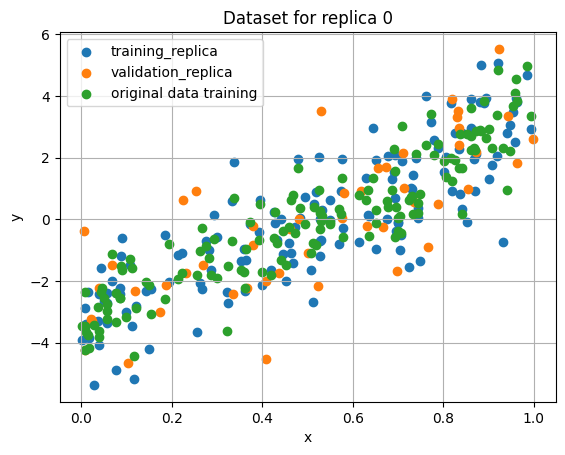

In [5]:
plt.scatter(all_data[ex_rep]['x_tr'],all_data[ex_rep]['y_tr'], label='training_replica')
plt.scatter(all_data[ex_rep]['x_val'],all_data[ex_rep]['y_val'], label='validation_replica')
plt.scatter(x_exp_data_tr, y_exp_data_tr, label="original data training" )
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dataset for replica ' + str(ex_rep) )
plt.legend()

## Let's now build the model

It is time to build the model that will fit all the replicas. Since we are going to define several models (one for each replica), let's create a function...

In [6]:
def make_model(number_of_layers, number_of_units_per_layer):
    input_la = keras.Input(shape=(1,)) #input layer
    model = keras.Sequential([input_la])
    for _, acti_func in zip(range(number_of_layers), activation): #inclusion of all the other layers with respective act. function
        model.add(layers.Dense(number_of_units_per_layer, activation=acti_func))
    model.add(layers.Dense(1)) #output layer
    return model

This function constructs a model in **tensoflow** with the number of layer and the number of units for each layer given as input. Moreover, it sets the activation function for each layer as given in `activation`.

Now let's create a model for each replica. In doing so we need to call the function `make_model` and also we need to set a few parameters:

- The *loss_function*, which is the function the algorithm will try to minimize. In this case we choose the `MeanSquaredError` 
- The *optimizer*, which is the algorithm used to minimize the loss function. In this case we are using `SGD`. For this optimizer we also need to set the learning rate, which is a measure of how "aggressive" the optimizer is.

In the cell below we can also see the summary of the model for our example replica.

In [7]:
all_models = {}
#We construct a model for each replica 
for rep in range(number_of_replica):
    model = make_model(number_of_layers, number_of_units)
    loss_mse = keras.losses.MeanSquaredError() #loss function
    opt_SGD = keras.optimizers.SGD(learning_rate = l_rate ) #optimizer
    model.compile(loss=loss_mse, optimizer = opt_SGD)
    all_models[rep] = model

In [8]:
all_models[ex_rep].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                30        
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 15)                240       
                                                                 
 dense_3 (Dense)             (None, 15)                240       
                                                                 
 dense_4 (Dense)             (None, 1)                 16        
                                                                 
Total params: 766
Trainable params: 766
Non-trainable params: 0
_________________________________________________________________


## Let's train all the models

It is finally time to train all the models to their own replica data. To do that we just need to call the function `fit()` which takes as input

1. The x and y traning data.
2. The number of epochs (i.e. the number of iterations of the optimizer)
3. The x and y validation data

Once we run the training for each replica we get the history of the training and validation losses as output. 

In [9]:
all_histories = {}
for rep in all_models:
    all_histories[rep] = all_models[rep].fit(x = all_data[rep]['x_tr'], y = all_data[rep]['y_tr'], batch_size = len(all_data[rep]['x_tr']), epochs = epochs, validation_data = (all_data[rep]['x_val'],all_data[rep]['y_val']))

Epoch 1/500
1/1 [==============================] - ETA: 0s - loss: 5.5242

2023-07-20 16:29:54.495110: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 260ms/step - loss: 5.5242 - val_loss: 5.7606
Epoch 2/500
1/1 [==============================] - 0s 9ms/step - loss: 5.4629 - val_loss: 5.7207
Epoch 3/500
1/1 [==============================] - 0s 11ms/step - loss: 5.4190 - val_loss: 5.6921
Epoch 4/500
1/1 [==============================] - 0s 11ms/step - loss: 5.3871 - val_loss: 5.6712
Epoch 5/500
1/1 [==============================] - 0s 10ms/step - loss: 5.3632 - val_loss: 5.6555
Epoch 6/500
1/1 [==============================] - 0s 11ms/step - loss: 5.3450 - val_loss: 5.6433
Epoch 7/500
1/1 [==============================] - 0s 10ms/step - loss: 5.3307 - val_loss: 5.6335
Epoch 8/500
1/1 [==============================] - 0s 10ms/step - loss: 5.3191 - val_loss: 5.6253
Epoch 9/500
1/1 [==============================] - 0s 11ms/step - loss: 5.3093 - val_loss: 5.6183
Epoch 10/500
1/1 [==============================] - 0s 10ms/step - loss: 5.3008 - val_loss: 5.6120
Epoch 11/500
1/1 [=============

1/1 [==============================] - 0s 10ms/step - loss: 4.7297 - val_loss: 5.0899
Epoch 85/500
1/1 [==============================] - 0s 9ms/step - loss: 4.7156 - val_loss: 5.0767
Epoch 86/500
1/1 [==============================] - 0s 10ms/step - loss: 4.7011 - val_loss: 5.0633
Epoch 87/500
1/1 [==============================] - 0s 10ms/step - loss: 4.6863 - val_loss: 5.0495
Epoch 88/500
1/1 [==============================] - 0s 10ms/step - loss: 4.6711 - val_loss: 5.0353
Epoch 89/500
1/1 [==============================] - 0s 11ms/step - loss: 4.6555 - val_loss: 5.0208
Epoch 90/500
1/1 [==============================] - 0s 10ms/step - loss: 4.6395 - val_loss: 5.0059
Epoch 91/500
1/1 [==============================] - 0s 10ms/step - loss: 4.6231 - val_loss: 4.9907
Epoch 92/500
1/1 [==============================] - 0s 10ms/step - loss: 4.6062 - val_loss: 4.9750
Epoch 93/500
1/1 [==============================] - 0s 9ms/step - loss: 4.5889 - val_loss: 4.9589
Epoch 94/500
1/1 [=======

1/1 [==============================] - 0s 10ms/step - loss: 2.0658 - val_loss: 2.6752
Epoch 167/500
1/1 [==============================] - 0s 10ms/step - loss: 2.0384 - val_loss: 2.6515
Epoch 168/500
1/1 [==============================] - 0s 9ms/step - loss: 2.0121 - val_loss: 2.6291
Epoch 169/500
1/1 [==============================] - 0s 10ms/step - loss: 1.9871 - val_loss: 2.6076
Epoch 170/500
1/1 [==============================] - 0s 9ms/step - loss: 1.9632 - val_loss: 2.5873
Epoch 171/500
1/1 [==============================] - 0s 10ms/step - loss: 1.9406 - val_loss: 2.5679
Epoch 172/500
1/1 [==============================] - 0s 10ms/step - loss: 1.9191 - val_loss: 2.5497
Epoch 173/500
1/1 [==============================] - 0s 9ms/step - loss: 1.8987 - val_loss: 2.5324
Epoch 174/500
1/1 [==============================] - 0s 9ms/step - loss: 1.8794 - val_loss: 2.5160
Epoch 175/500
1/1 [==============================] - 0s 9ms/step - loss: 1.8613 - val_loss: 2.5007
Epoch 176/500
1/1 [

1/1 [==============================] - 0s 10ms/step - loss: 1.6083 - val_loss: 2.2660
Epoch 249/500
1/1 [==============================] - 0s 9ms/step - loss: 1.6078 - val_loss: 2.2652
Epoch 250/500
1/1 [==============================] - 0s 10ms/step - loss: 1.6072 - val_loss: 2.2641
Epoch 251/500
1/1 [==============================] - 0s 9ms/step - loss: 1.6066 - val_loss: 2.2631
Epoch 252/500
1/1 [==============================] - 0s 9ms/step - loss: 1.6060 - val_loss: 2.2621
Epoch 253/500
1/1 [==============================] - 0s 10ms/step - loss: 1.6055 - val_loss: 2.2608
Epoch 254/500
1/1 [==============================] - 0s 9ms/step - loss: 1.6048 - val_loss: 2.2598
Epoch 255/500
1/1 [==============================] - 0s 11ms/step - loss: 1.6042 - val_loss: 2.2588
Epoch 256/500
1/1 [==============================] - 0s 11ms/step - loss: 1.6036 - val_loss: 2.2576
Epoch 257/500
1/1 [==============================] - 0s 9ms/step - loss: 1.6030 - val_loss: 2.2567
Epoch 258/500
1/1 [

1/1 [==============================] - 0s 10ms/step - loss: 1.5636 - val_loss: 2.1981
Epoch 331/500
1/1 [==============================] - 0s 10ms/step - loss: 1.5631 - val_loss: 2.1976
Epoch 332/500
1/1 [==============================] - 0s 9ms/step - loss: 1.5626 - val_loss: 2.1970
Epoch 333/500
1/1 [==============================] - 0s 10ms/step - loss: 1.5622 - val_loss: 2.1964
Epoch 334/500
1/1 [==============================] - 0s 9ms/step - loss: 1.5617 - val_loss: 2.1959
Epoch 335/500
1/1 [==============================] - 0s 10ms/step - loss: 1.5612 - val_loss: 2.1953
Epoch 336/500
1/1 [==============================] - 0s 9ms/step - loss: 1.5607 - val_loss: 2.1947
Epoch 337/500
1/1 [==============================] - 0s 10ms/step - loss: 1.5602 - val_loss: 2.1943
Epoch 338/500
1/1 [==============================] - 0s 10ms/step - loss: 1.5597 - val_loss: 2.1936
Epoch 339/500
1/1 [==============================] - 0s 9ms/step - loss: 1.5592 - val_loss: 2.1931
Epoch 340/500
1/1 

1/1 [==============================] - 0s 10ms/step - loss: 1.5257 - val_loss: 2.1766
Epoch 413/500
1/1 [==============================] - 0s 10ms/step - loss: 1.5254 - val_loss: 2.1765
Epoch 414/500
1/1 [==============================] - 0s 9ms/step - loss: 1.5251 - val_loss: 2.1764
Epoch 415/500
1/1 [==============================] - 0s 10ms/step - loss: 1.5248 - val_loss: 2.1764
Epoch 416/500
1/1 [==============================] - 0s 10ms/step - loss: 1.5244 - val_loss: 2.1763
Epoch 417/500
1/1 [==============================] - 0s 9ms/step - loss: 1.5242 - val_loss: 2.1761
Epoch 418/500
1/1 [==============================] - 0s 9ms/step - loss: 1.5238 - val_loss: 2.1760
Epoch 419/500
1/1 [==============================] - 0s 10ms/step - loss: 1.5235 - val_loss: 2.1760
Epoch 420/500
1/1 [==============================] - 0s 10ms/step - loss: 1.5232 - val_loss: 2.1759
Epoch 421/500
1/1 [==============================] - 0s 11ms/step - loss: 1.5229 - val_loss: 2.1758
Epoch 422/500
1/1

1/1 [==============================] - 0s 10ms/step - loss: 1.5078 - val_loss: 2.1676
Epoch 495/500
1/1 [==============================] - 0s 9ms/step - loss: 1.5076 - val_loss: 2.1674
Epoch 496/500
1/1 [==============================] - 0s 9ms/step - loss: 1.5075 - val_loss: 2.1673
Epoch 497/500
1/1 [==============================] - 0s 9ms/step - loss: 1.5073 - val_loss: 2.1673
Epoch 498/500
1/1 [==============================] - 0s 11ms/step - loss: 1.5071 - val_loss: 2.1671
Epoch 499/500
1/1 [==============================] - 0s 10ms/step - loss: 1.5069 - val_loss: 2.1668
Epoch 500/500
1/1 [==============================] - 0s 9ms/step - loss: 1.5067 - val_loss: 2.1666


### Let's look at the training/valdation losses for an example replica

We can have a look to the loss values as a function of the epoch for our example replica. We can see that after about 200 epochs the values of both the training and validation losses are more or less stable.  

In [10]:
hist = pd.DataFrame(all_histories[ex_rep].history)
hist['epoch'] = all_histories[ex_rep].epoch
hist.tail()

,loss,val_loss,epoch
495,1.507475,2.167281,495
496,1.507313,2.167251,496
497,1.507143,2.167053,497
498,1.506949,2.166812,498
499,1.506739,2.166649,499


In [11]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

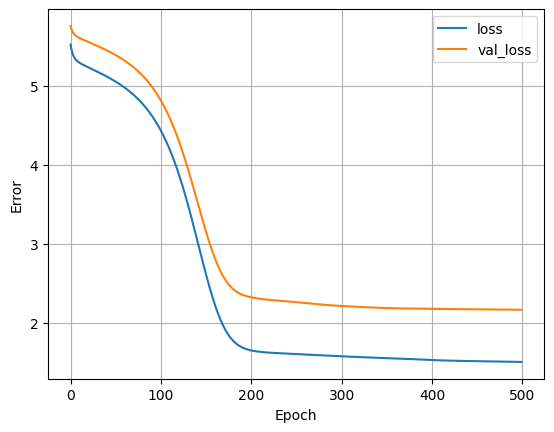

In [12]:
plot_loss(all_histories[ex_rep])

### Now let's look to predictions 

Let's now try to reconstruct the original function asking the models to predict the function over a linear grid in x.  We then plot data, predictions and real function for each replica.

In [19]:
x = tf.linspace(0.0, 1.0, 50) #simple grid in x
all_y_predicted = {} #predictions for each replica 
for rep in range(number_of_replica):
    y = all_models[rep].predict(x)
    all_y_predicted[rep] = y

2/2 [==============================] - 0s 1ms/step


In [20]:
#this function plots the training and validation data for a certain replica, together with our prediction and real function
def plot_fit(x, y, x_tr_rep, y_tr_rep, x_val_rep, y_val_rep):
  plt.scatter(x_tr_rep, y_tr_rep, label='Training_Data')
  plt.scatter(x_val_rep, y_val_rep, label='Validation_Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.plot(x, [func_to_fit(i, 0) for i in x], label='Real function', color='red')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()

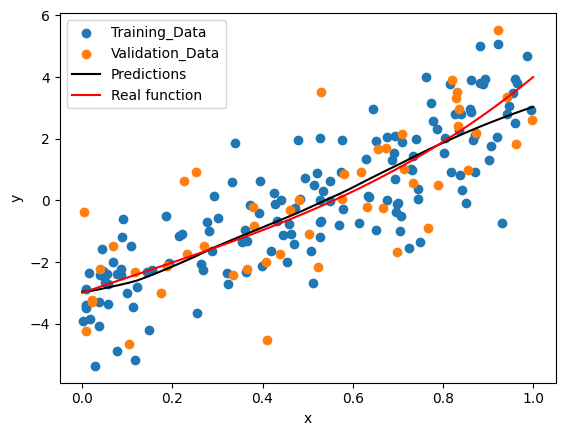

In [21]:
for rep in range(number_of_replica):
    plot_fit(x, all_y_predicted[rep], all_data[rep]['x_tr'], all_data[rep]['y_tr'], all_data[rep]['x_val'], all_data[rep]['y_val'])
    plt.show()
    plt.close()

We can do even something more: we can construct the envelope of the predictions of all our replicas to construct a central prediction (given by the mean over the replicas) and an uncertainty band (given by the standard deviation of the sample). 

In [16]:
# This creates the envelope of the replica producing a central prediction with a std deviation
def compute_central_pred_and_uncert(all_y_predicted):
    average_y = 0.
    std_y = 0.
    for rep in all_y_predicted:
        average_y += all_y_predicted[rep]
    central_y = average_y/len(all_y_predicted)
    for rep in all_y_predicted:
        std_y += (all_y_predicted[rep] - central_y) ** 2
    std_y = np.sqrt(std_y / (len(all_y_predicted) - 1)) if len(all_y_predicted) != 1 else 0.
    return central_y, std_y

In [17]:
all_y_central, all_y_std = compute_central_pred_and_uncert(all_y_predicted)

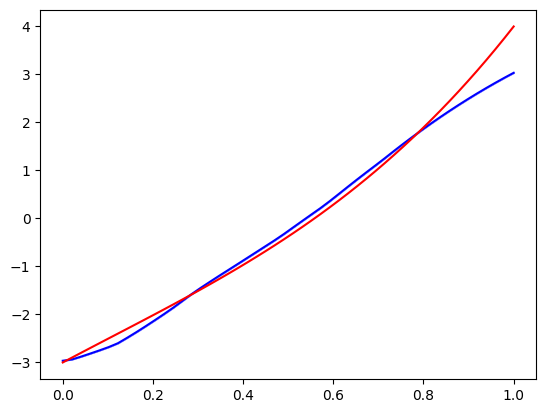

In [18]:
plt.plot(x, all_y_central, color = "blue")
plt.fill_between(x, [unc for unc in ((all_y_central + all_y_std).transpose())[0]], [unc for unc in ((all_y_central - all_y_std).transpose())[0]], color = "blue", alpha=0.3)
plt.plot(x, [func_to_fit(i, 0) for i in x], label='Real function', color='red')
#plt.fill_between(x, np.array([func_to_fit(i, 0) for i in x]) + dev_std_exp, np.array([func_to_fit(i, 0) for i in x]) - dev_std_exp, color="red" )